In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [89]:
df = pd.read_csv("Close_Return_SPY.csv")

In [90]:
# Dropping Continuous Label and adding Month of the year feature
df = df.drop("OUTPUT", axis = 1)
df["month"]=pd.to_datetime(df["Date"]).apply(lambda date:date.month)
df = df.set_index("Date")

In [91]:
# checking for nulls
df.isnull().sum().sum()

0

In [92]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AUDUSD,1157.0,0.775025,0.142401,0.484700,0.701800,0.757700,0.878200,1.099500
EURODOLLAR,1157.0,98.148157,1.834885,93.060000,97.350000,98.800000,99.690000,99.882000
EURUSD,1157.0,1.205647,0.158457,0.838600,1.114400,1.206700,1.322200,1.594200
CRUDE,1157.0,62.058401,25.819557,16.940000,41.250000,59.240000,81.430000,145.290000
COPPER,1157.0,2.592371,1.118287,0.612000,1.625000,2.833000,3.378000,4.937500
...,...,...,...,...,...,...,...,...
BAA_5W-10WR,1157.0,0.001623,0.046929,-0.298374,-0.019048,0.006086,0.025769,0.209045
AAA_5W-10WR,1157.0,0.002156,0.053034,-0.188260,-0.022786,0.005374,0.030257,0.384521
SPY_5W-10WR,1157.0,-0.006072,0.052540,-0.254620,-0.034745,-0.012899,0.016840,0.398576
1_up_0_down,1157.0,0.558341,0.496799,0.000000,0.000000,1.000000,1.000000,1.000000


In [93]:
df.head()

,AUDUSD,EURODOLLAR,EURUSD,CRUDE,COPPER,VIX,GOLD,EWJ,EWH,EWG,...,USDCHF_5W-10WR,US10Y_5W-10WR,SILVER_5W-10WR,MOR30Y_5W-10WR,MOR15Y_5W-10WR,BAA_5W-10WR,AAA_5W-10WR,SPY_5W-10WR,1_up_0_down,month
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-17,0.6068,93.63,0.9724,30.91,0.805,22.37,284.1,60.00,13.56,28.00,...,-0.040080,-0.011844,-0.033749,-0.025397,-0.029268,-0.006170,0.005215,0.051321,1,3
2000-03-24,0.6083,93.64,0.9771,28.02,0.804,23.31,284.7,59.75,13.81,28.44,...,-0.021629,0.029271,-0.030575,-0.024012,-0.027712,0.005967,0.012671,0.090036,0,3
2000-03-31,0.6076,93.66,0.9562,26.90,0.800,24.11,278.4,66.00,13.69,27.00,...,-0.034187,0.060839,0.035505,-0.005995,-0.007556,0.017880,0.026511,0.086754,1,3
2000-04-07,0.5985,93.69,0.9549,25.04,0.765,24.39,279.8,63.75,13.50,26.56,...,-0.014284,0.038397,0.039232,-0.002404,0.000000,-0.007194,0.002544,-0.041384,0,4
2000-04-14,0.5976,93.71,0.9623,25.57,0.751,33.49,282.6,60.50,12.06,25.06,...,-0.022034,0.023924,0.088759,0.002392,0.005063,-0.019395,-0.010309,0.016813,1,4


<AxesSubplot:xlabel='1_up_0_down', ylabel='count'>

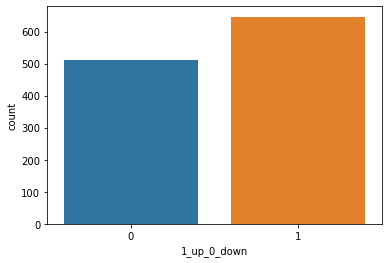

In [94]:
# distribution of the output label... looks quite balanced
sns.countplot(x = df["1_up_0_down"])

In [95]:
# abs correlation of top correlated to output
abs(df.corr()["1_up_0_down"]).nlargest(5)

1_up_0_down    1.000000
MOR30Y         0.098525
MOR15Y         0.097165
BAA            0.094654
AAA            0.092801
Name: 1_up_0_down, dtype: float64

In [96]:
# top correlated to output
abs(df.corr()["1_up_0_down"]).nlargest(5).index

Index(['1_up_0_down', 'MOR30Y', 'MOR15Y', 'BAA', 'AAA'], dtype='object')

<AxesSubplot:>

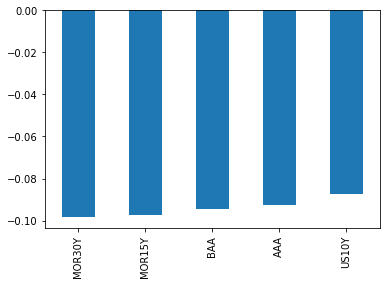

In [97]:
df.corr()["1_up_0_down"][abs(df.corr()["1_up_0_down"]).nlargest(6).index].drop("1_up_0_down").plot(kind = "bar")

In [147]:
# Preprocessing Data
X = df.drop("1_up_0_down",axis = 1).values
y = df["1_up_0_down"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating Model: DLM1
model = Sequential()

model.add(Dense(116,activation = "relu"))
model.add(Dropout(.2))
model.add(Dense(1,activation = "sigmoid"))
model.compile(optimizer = "adam", loss = "binary_crossentropy", )
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 50)

In [148]:
# Training DLM1
model.fit(x = X_train, y = y_train, epochs = 600,validation_data = (X_test,y_test), callbacks = [early_stop], batch_size = 80)

Epoch 1/600
11/11 [==============================] - 1s 15ms/step - loss: 0.7390 - val_loss: 0.7132
Epoch 2/600
11/11 [==============================] - 0s 6ms/step - loss: 0.7048 - val_loss: 0.6856
Epoch 3/600
11/11 [==============================] - 0s 6ms/step - loss: 0.6890 - val_loss: 0.6859
Epoch 4/600
11/11 [==============================] - 0s 6ms/step - loss: 0.7023 - val_loss: 0.7148
Epoch 5/600
11/11 [==============================] - 0s 6ms/step - loss: 0.6919 - val_loss: 0.6913
Epoch 6/600
11/11 [==============================] - 0s 6ms/step - loss: 0.6803 - val_loss: 0.6922
Epoch 7/600
11/11 [==============================] - 0s 6ms/step - loss: 0.6837 - val_loss: 0.6914
Epoch 8/600
11/11 [==============================] - 0s 6ms/step - loss: 0.6850 - val_loss: 0.6980
Epoch 9/600
11/11 [==============================] - 0s 6ms/step - loss: 0.6853 - val_loss: 0.6958
Epoch 10/600
11/11 [==============================] - 0s 6ms/step - loss: 0.6816 - val_loss: 0.6948
Epoch 11

<AxesSubplot:>

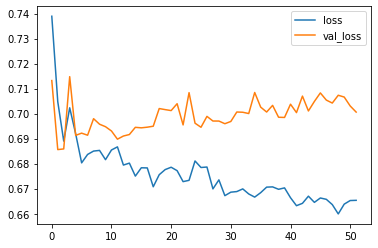

In [149]:
# Overfitting?
pd.DataFrame(model.history.history).plot()

In [150]:
# Evaluating DLM1
predictions = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.48      0.42      0.45       125
           1       0.60      0.66      0.63       165

    accuracy                           0.56       290
   macro avg       0.54      0.54      0.54       290
weighted avg       0.55      0.56      0.55       290

[[ 52  73]
 [ 56 109]]


In [134]:
# KNN1
from sklearn.neighbors import KNeighborsClassifier
X = df.drop("1_up_0_down",axis = 1).values
y = df["1_up_0_down"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train,y_train)
p1 = knn.predict(X_test)
print(classification_report(y_test,p1))
print(confusion_matrix(y_test,p1))

              precision    recall  f1-score   support

           0       0.45      0.46      0.45       126
           1       0.58      0.57      0.57       164

    accuracy                           0.52       290
   macro avg       0.51      0.51      0.51       290
weighted avg       0.52      0.52      0.52       290

[[58 68]
 [71 93]]


Text(0, 0.5, 'Error Rate')

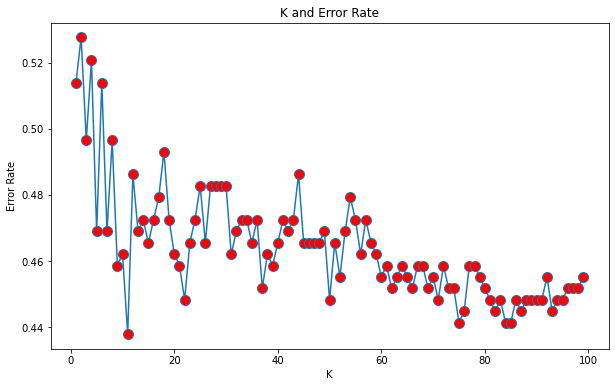

In [122]:
error_rate = []
for i in range (1,100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    p1 = knn.predict(X_test)
    error_rate.append(np.mean(p1 != y_test))
plt.figure(figsize = (10,6))
plt.plot(range(1,100),error_rate, marker = "o", markerfacecolor= "red", markersize = 10)
plt.title("K and Error Rate")
plt.xlabel("K")
plt.ylabel("Error Rate")

In [123]:
# KNN1 Adjusted with K = 80
knn = KNeighborsClassifier(n_neighbors = 80)
knn.fit(X_train,y_train)
p1 = knn.predict(X_test)
print(classification_report(y_test,p1))
print(confusion_matrix(y_test,p1))

              precision    recall  f1-score   support

           0       0.58      0.05      0.10       133
           1       0.55      0.97      0.70       157

    accuracy                           0.55       290
   macro avg       0.57      0.51      0.40       290
weighted avg       0.56      0.55      0.42       290

[[  7 126]
 [  5 152]]


In [124]:
# DECISION TREE 1: DT1
#DECISION TREE IMPORTS
from sklearn.tree import DecisionTreeClassifier
#RANDOM FOREST IMPORTS
from sklearn.ensemble import RandomForestClassifier
X = df.drop("1_up_0_down",axis = 1).values
y = df["1_up_0_down"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
p1 = dtree.predict(X_test)
print(confusion_matrix(y_test,p1))
print(classification_report(y_test,p1))

[[62 73]
 [77 78]]
              precision    recall  f1-score   support

           0       0.45      0.46      0.45       135
           1       0.52      0.50      0.51       155

    accuracy                           0.48       290
   macro avg       0.48      0.48      0.48       290
weighted avg       0.48      0.48      0.48       290



In [125]:
# RANDOM FOREST 1: RF1
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train,y_train)
p2 = rf.predict(X_test)
print(confusion_matrix(y_test,p2))
print(classification_report(y_test,p2))

[[ 28 107]
 [ 41 114]]
              precision    recall  f1-score   support

           0       0.41      0.21      0.27       135
           1       0.52      0.74      0.61       155

    accuracy                           0.49       290
   macro avg       0.46      0.47      0.44       290
weighted avg       0.46      0.49      0.45       290

